In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from skimage.io import imread
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import IncrementalPCA
from sklearn_projects.image_processing.quickdraw.imagebuilder \
    import QuickDrawImageBuilder as ImageBuilder
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import datasets, layers, models, Input, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

from IPython.display import clear_output

# QuickDraw dataset GAN.

Let's try creating a generative adversarial network (GAN) for the QuickDraw dataset.
If successful, this will give us a model capable of "hallucinating" drawings based on the
training data available in the QuickDraw datasets.

Note this assumes you already have directories containing the .png image files
generated in `sklearn_projects/image_processing/quickdraw_analysis.ipynb`.

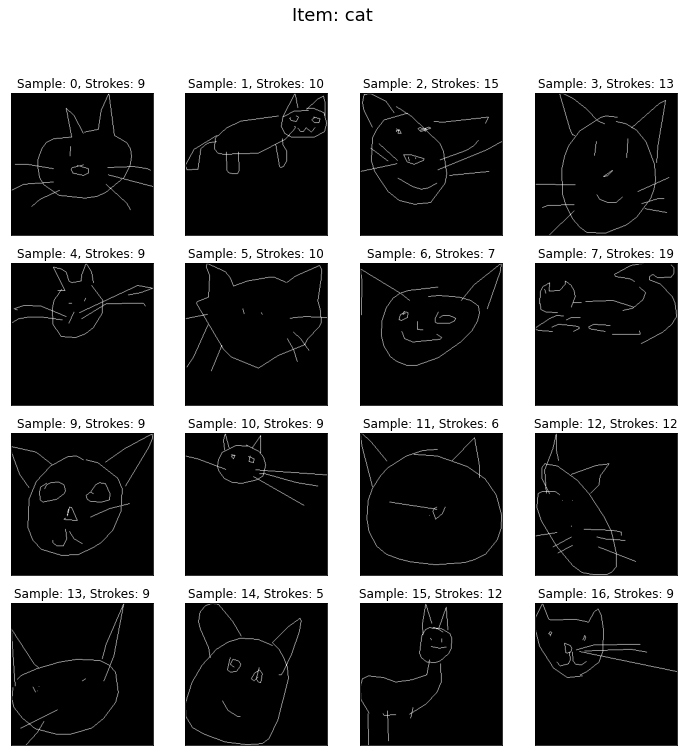

In [2]:
# pull in data and visualize
###############
data_names = ['cat']
path_to_data = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/'
###############

for data_name in data_names:

    # data location
    image_path = path_to_data + 'output_images/' + data_name + '/images/'

    # meta file
    meta_df = pd.read_csv(path_to_data + 'output_images/' + data_name + '/meta/meta.csv')
    # print(meta_df['recognized'].value_counts())

    # get image indices of recognized images:
    image_indices = meta_df[meta_df['recognized']==True]['sample_id'].values.tolist()

    plt.figure(figsize=(12,12))
    for plot_index, sample_id in enumerate(image_indices[:16]):
        sample = imread(image_path+'sample{}.png'.format(sample_id),
                        as_gray=True)
        plt.subplot(4,4,plot_index+1)
        plt.imshow(sample,
                   cmap='gray')
        plt.xticks([])
        plt.yticks([])
        num_strokes = meta_df[meta_df['sample_id'] == sample_id]['num_strokes'].values.tolist()[0]
        plt.title('Sample: {}, Strokes: {}'.format(sample_id, num_strokes))
    plt.suptitle('Item: {}'.format(data_name),
                 fontsize=18)
    plt.show();

In [3]:
# define input dataset
################
image_class = 'cat'
path_to_class_images = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/output_images/'
seed = 18210
val_split = 0.2
batch_size = 64
image_size = (64, 64)  # downsampling from original (256, 256) to speed training
################

train_dataset = image_dataset_from_directory(directory=path_to_class_images + '{}/'.format(image_class),
                                             label_mode=None,
                                             seed=seed,
                                             validation_split=val_split,
                                             batch_size=batch_size,
                                             image_size=image_size,
                                             color_mode='grayscale',
                                             interpolation='area',
                                             subset='training')

val_dataset = image_dataset_from_directory(directory=path_to_class_images + '{}/'.format(image_class),
                                           label_mode=None,
                                           seed=seed,
                                           validation_split=val_split,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           color_mode='grayscale',
                                           interpolation='area',
                                           subset='validation')


Found 66918 files belonging to 2 classes.
Using 53535 files for training.
Found 66918 files belonging to 2 classes.
Using 13383 files for validation.


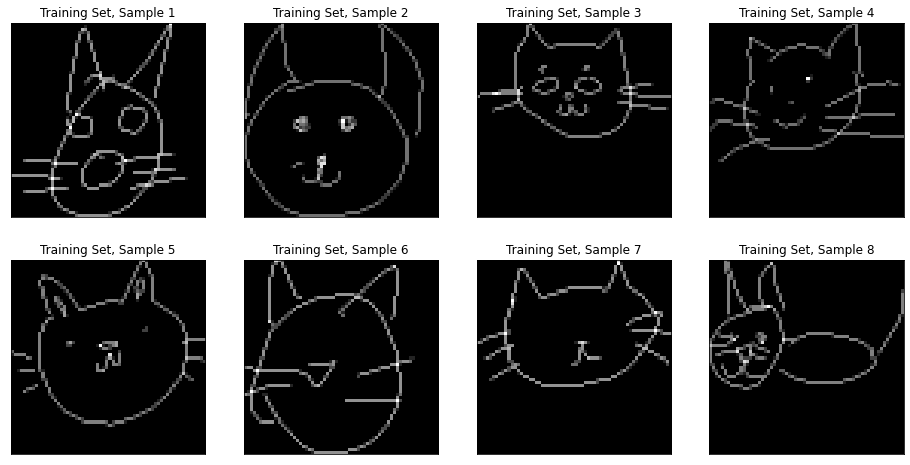

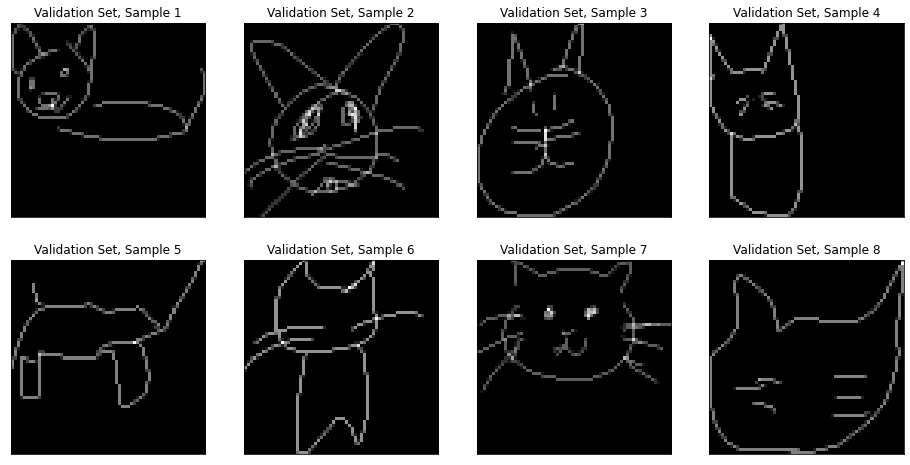

In [4]:
# viz. training data samples
dataset_names = ['Training', 'Validation']
for dataset_index, dataset in enumerate([train_dataset, val_dataset]):
    plt.figure(figsize = (16,8))
    for batch in dataset.take(1):
        for i in range(8):
            image = batch[i,:,:,0]
            plt.subplot(2, 4, i + 1)
            plt.imshow(image,
                       cmap='gray')
            plt.title('{} Set, Sample {}'.format(dataset_names[dataset_index],
                                                str(i+1)))
            plt.xticks([])
            plt.yticks([])

In [5]:
######################
# discriminator inputs
dropout_prob = 0.5
padding = 'same'
leakyrelu_alpha = -1./5.5
######################

# define the discriminator network
def get_discriminator(image_input_shape=(256, 256, 1),
                      dropout_prob = 0.4,
                      padding = 'same',
                      leakyrelu_alpha = -1./5.5):
    """
    Build the discriminator model.

    This model takes as input an image, and outputs whether this image is
    a real or fake example from the target dataset.

    :param image_input_shape: the shape of the input image.
    :param dropout_prob: dropout probability. If 0, dropout layers will not be added.
    :param padding: type of padding for Conv2D and MaxPooling2D layers. Either 'same' or 'valid',
     defaults to 'same'.
    :return: model: the discriminator model.
    """

    # input
    image_input = Input(shape=image_input_shape)

    # model
    #########
    # 1st conv. layer
    #########
    x = Conv2D(filters=64,
               kernel_size=(5, 5),
               strides=(1, 1),
               padding=padding,
               kernel_initializer='glorot_normal')(image_input)
    x = MaxPooling2D(pool_size=(2,2),
                     padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # 2nd conv. layer
    #########
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               strides=(1, 1),
               padding=padding,
               kernel_initializer='glorot_normal')(x)
    x = MaxPooling2D(pool_size=(2,2),
                     padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # 3rd conv. layer
    #########
    x = Conv2D(filters=16,
               kernel_size=(3, 3),
               strides=(1, 1),
               padding=padding,
               kernel_initializer='glorot_normal')(x)
    x = MaxPooling2D(pool_size=(2,2),
                     padding='same')(x)
    x = LeakyReLU(alpha=leakyrelu_alpha)(x)
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)
    #########
    # output
    #########
    x = Flatten()(x)
    x = Dense(units=1,
              activation='sigmoid')(x)
    discriminator = Model(inputs=image_input,
                          outputs=x,
                          name='discriminator')

    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

    return discriminator

discriminator = get_discriminator(image_input_shape=(image_size[0], image_size[1], 1),
                                  dropout_prob=dropout_prob,
                                  padding=padding,
                                  leakyrelu_alpha=leakyrelu_alpha)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)      

In [6]:
######################
# generator inputs
gen_input_shape = (75,)
padding = 'same'
batchnorm_momentum = 0.8
initial_depth = 30
initial_width = 8
leakyrelu_alpha = -1./5.5
dropout_prob = 0.5
######################

# and build the generator model

def get_generator(gen_input_shape=(100,),
                  padding='same',
                  batchnorm_momentum=0.8,
                  initial_depth=256,
                  initial_width=11,
                  leakyrelu_alpha=-1./5.5,
                  dropout_prob=0.4):

    # input
    gen_input = Input(shape=gen_input_shape)

    # model
    ###########
    # build and shape tensor for inverse convolution
    ###########
    y = Dense(initial_depth*initial_width*initial_width)(gen_input)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    y = Reshape((initial_width, initial_width, initial_depth))(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 1st Conv2dTranspose
    ###########
    # y = Conv2DTranspose(filters=int(initial_depth/2),
    #                     kernel_size=(3, 3),
    #                     strides=(2,2),
    #                     padding=padding,
    #                     kernel_initializer='glorot_normal')(y)
    # y = BatchNormalization(momentum=batchnorm_momentum)(y)
    # y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    # if dropout_prob > 0:
    #     y = Dropout(dropout_prob)(y)
    ###########
    # 2nd Conv2dTranspose
    ###########
    y = Conv2DTranspose(filters=int(initial_depth/4),
                        kernel_size=(3, 3),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal')(y)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 3rd Conv2dTranspose
    ###########
    y = Conv2DTranspose(filters=int(initial_depth/8),
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal')(y)
    y = BatchNormalization(momentum=batchnorm_momentum)(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    if dropout_prob > 0:
        y = Dropout(dropout_prob)(y)
    ###########
    # 4th Conv2dTranspose
    ###########
    # y = Conv2DTranspose(filters=int(initial_depth/16),
    #                     kernel_size=(5, 5),
    #                     strides=(2, 2),
    #                     padding=padding,
    #                     kernel_initializer='glorot_normal')(y)
    # y = BatchNormalization(momentum=batchnorm_momentum)(y)
    # y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    # if dropout_prob > 0:
    #     y = Dropout(dropout_prob)(y)
    ##########
    # output
    ##########
    y = Conv2DTranspose(filters = 1,
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding=padding,
                        kernel_initializer='glorot_normal')(y)
    y = LeakyReLU(alpha=leakyrelu_alpha)(y)
    generator = Model(inputs=gen_input,
                      outputs=y,
                      name='generator')

    return generator

generator = get_generator(gen_input_shape=gen_input_shape,
                          padding=padding,
                          batchnorm_momentum=batchnorm_momentum,
                          initial_depth=initial_depth,
                          initial_width=initial_width,
                          leakyrelu_alpha=leakyrelu_alpha,
                          dropout_prob=dropout_prob)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1920)              145920    
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1920)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 30)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 30)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 7)         18

In [7]:
# define adversarial model
def get_adversarial(generator,
                    discriminator):
    adversarial = Sequential(name='adversarial')
    adversarial.add(generator)
    adversarial.add(discriminator)

    # compile
    optimizer = keras.optimizers.Adam(learning_rate=0.00002)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics='accuracy')

    return adversarial

adversarial = get_adversarial(generator,
                              discriminator)
adversarial.summary()

Model: "adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Functional)       (None, 64, 64, 1)         156141    
_________________________________________________________________
discriminator (Functional)   (None, 1)                 25777     
Total params: 181,918
Trainable params: 178,058
Non-trainable params: 3,860
_________________________________________________________________


Epoch: 1, Batch: 151
    Adv. Loss: 0.189045, Adv. Acc: 1.000000.
    Dis. Loss: 0.325181, Dis. Acc: 0.976562.



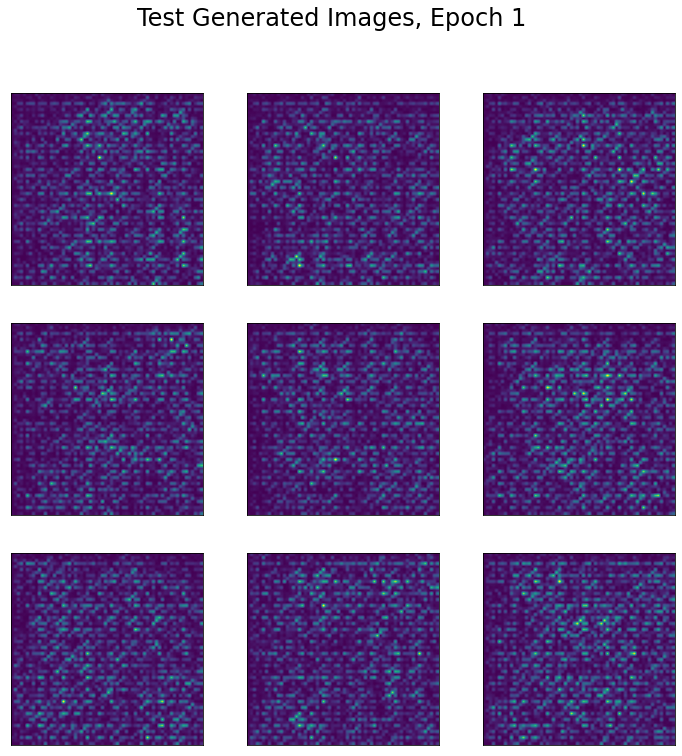

KeyboardInterrupt: 

In [8]:
# train the GAN!
# TODO: implement training

##############
# inputs
train_steps = 100
batch_lim = 200
##############

adv_losses = []
dis_losses = []
epoch = 0

# visualization
viz_noise = np.random.uniform(-1.0, 1.0, size=[9,
                                               gen_input_shape[0]])

for step in range(train_steps):
    epoch += 1
    batch_count = 0
    for batch in train_dataset.batch(batch_size=1,
                                     drop_remainder=True):
        batch_count += 1
        if batch_count > batch_lim:
            break
        noise = np.random.uniform(-1., 1., size=[batch_size,
                                                 gen_input_shape[0]])
        true_images = batch[0,:,:,:,:]

        # gen. fake images
        fake_images = generator.predict(noise)

        # build training data
        x = np.concatenate((true_images, fake_images))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0  # 1 true, 0 fake

        # train discriminator
        discrim_loss = discriminator.train_on_batch(x, y)
        # dis_losses += [discrim_loss]

        # get adversarial data (generated only)
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size,
                                                   gen_input_shape[0]])
        y = np.ones([batch_size, 1])

        # train adversarial (generator and discriminator)
        adv_loss = adversarial.train_on_batch(noise, y)
        # adv_losses += [adv_loss]
        # if step%5 == 0:
        if batch_count%10 == 0:
            clear_output(wait=True)
            print('Epoch: {}, Batch: {}'.format(step+1, batch_count+1))
            print('    Adv. Loss: {:.6f}, Adv. Acc: {:.6f}.'.format(adv_loss[0], adv_loss[1]))
            print('    Dis. Loss: {:.6f}, Dis. Acc: {:.6f}.\n'.format(discrim_loss[0], discrim_loss[1]))
            plt.figure(10,
                       figsize=(12, 12))
            viz_images = generator.predict(viz_noise)
            for viz_image in range(viz_images.shape[0]):
                plt.subplot(3, 3, viz_image + 1)
                plt.imshow(viz_images[viz_image,:,:,0])
                plt.xticks([])
                plt.yticks([])
            plt.suptitle('Test Generated Images, Epoch {}'.format(epoch),
                         fontsize=24)
            plt.show()


In [ ]:
# for i, batch in enumerate(train_dataset.batch(batch_size=1,
#                                               drop_remainder=True)):
#     if i%10 == 0:
#         print(i, batch[0,:,:,:,:].shape)

In [ ]:
# noise = np.random.uniform(-1.0, 1.0, size=[9,
#                                            gen_input_shape[0]])
# gen_images = generator.predict(noise)
# gen_images.shape

## Hard lessons:

1. The first inverse convolutional layer of the generator should have channels of sufficient width (>8 pixels),
 or the results won't have enough "expressiveness." That is, outputs will have a tiled/quilted structure.